### Explore Cora Graph Dataset

In [2]:
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.transforms import NormalizeFeatures

dataset = Planetoid(root='data/Planetoid', name='Cora', transform=NormalizeFeatures())

**Planetoid** (short for Predictive Learning Approach for Network Information) is a benchmark dataset collection and framework designed to evaluate *semi-supervised node classification*.

**Cora** dataset is a *citation network* where the nodes are scientific research papers, the edges are the citation links between these papers and the class is academic topic of the paper such as Neural Nets, Rule learning, etc.

In [3]:
print('DATASET: \t', dataset)
print('# of graphs:\t', len(dataset))
print('# of features:\t', dataset.num_features)
print('# of classes:\t', dataset.num_classes)

DATASET: 	 Cora()
# of graphs:	 1
# of features:	 1433
# of classes:	 7


In [4]:
data = dataset[0]

print('# of nodes:', data.num_nodes)
print('# of edges:', data.num_edges)
print('\n edge_index:', data.edge_index.T[:10]) 
print(data.edge_index.shape) 

# of nodes: 2708
# of edges: 10556

 edge_index: tensor([[ 633,    0],
        [1862,    0],
        [2582,    0],
        [   2,    1],
        [ 652,    1],
        [ 654,    1],
        [   1,    2],
        [ 332,    2],
        [1454,    2],
        [1666,    2]])
torch.Size([2, 10556])


### Visualize network using NetworkX

In [8]:
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

def visualize(h, color):
    z = TSNE(n_components=2).fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

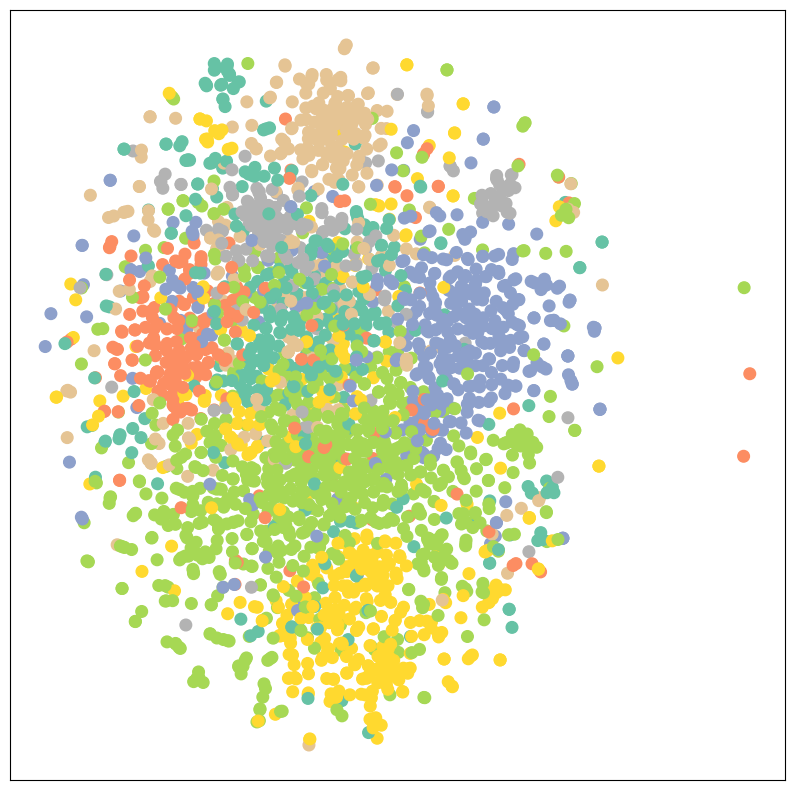

In [ ]:
visualize(data.x, color=data.y)

### Initialize GCN Model

In [6]:
import torch
from torch.nn import Linear
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = GCNConv(dataset.num_features, 120)
        self.linear = Linear(120, dataset.num_classes)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index) 
        h = x.relu()
        out = self.linear(h)
        return h, out

print(GCN())

GCN(
  (conv1): GCNConv(1433, 120)
  (linear): Linear(in_features=120, out_features=7, bias=True)
)


There are two key operations in a GCN model:


1. **Message Passing and Neighbor Aggregation**

    The GCNConv layer performs, for each node in the graph, an aggregation of the feature vectors of the node and its neighbors. Typically, this involves sum (or mean) aggregation and normalization (often degree-based).

    One GCN layer aggregates 1-hop neighbor information.Two stacked GCN layers aggregate up to 2-hop neighbors, and so on. That’s why we pass both the node features and the edge index (adjacency info) to the layer.

2. **Downsizing of Embedding and Classification**
    The GCN model transforms the initial **sparse, high-dimensional** node features into **dense, low-dimensional** embeddings. Each GCNConv(in_dim, out_dim) projects node features from ℝ^in_dim to ℝ^out_dim using a shared weight matrix.

    This projection allows us to:

    - Reduce dimensionality

    - Learn expressive representations

    - Enable node classification at the final layer

Final Embedding Shape torch.Size([2708, 120])


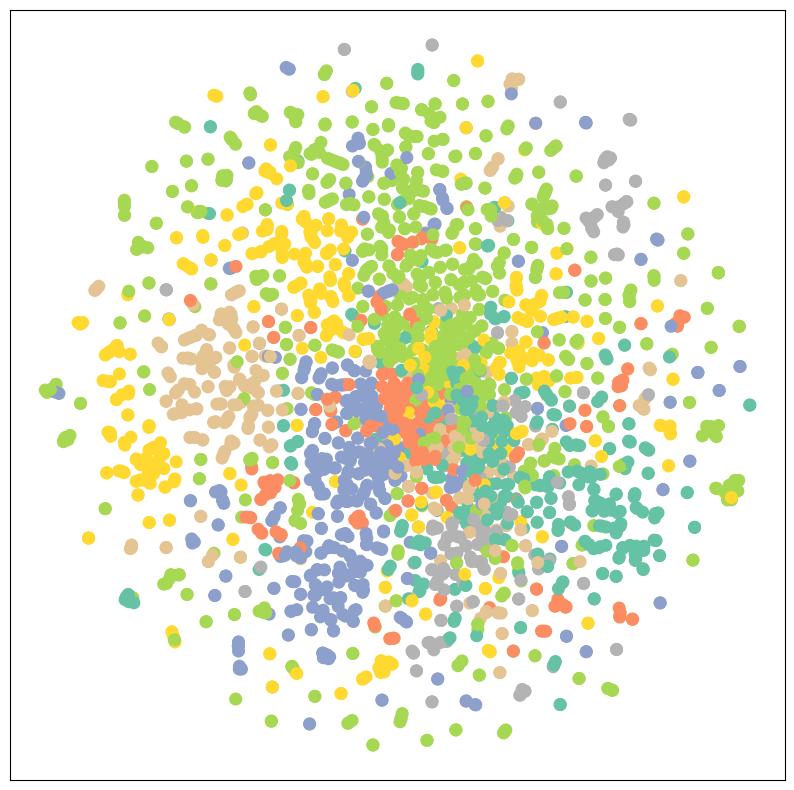

In [14]:
model = GCN()

x, out = model(data.x, data.edge_index)
print('Final Embedding Shape', x.shape)
visualize(x, data.y)

The intial node feature representation are usually **sparse, binary** and **high-dimensioal feature vectors**. This means that each node in the vector is a bag-of-word represetnation over some vocabulary, if the word exists in the paper then the value is 1 or else zero. So this representation is not a true embedding in a *learned* sense.

By passing the embeddings through our GCN model, we have trasformed the node embedding dimension into a new dimension, from 1433 to 120. This is a **dense embedding** that the model learns to capture all the info in the nodes into a **lower dimesnional space**, much like how Word2Vec or GloVe works.

Not only does it help reduce the complexity of the data, but also enforces the model to only retain important infromation in the data thgouh the process of  **inductive bias**. Inductive bias are the assumptions a model makes about the data in order to learn information from it; in CNNs for example we assume surrounding pixels are related, in GNNs we assume that neighboring nodes are related.

## Train GCN model

While training the model we are trying to **learn node embedding representations** that are **linearly seperable** to perform the final classification. During each training step we calculate the cross entropy loss between actual labels and predicted labels. We backpropogate this loss and updating the weight matrix to iteratively improve the quality of embeddings in each pass.

Epoch: 050, Loss: 0.4363


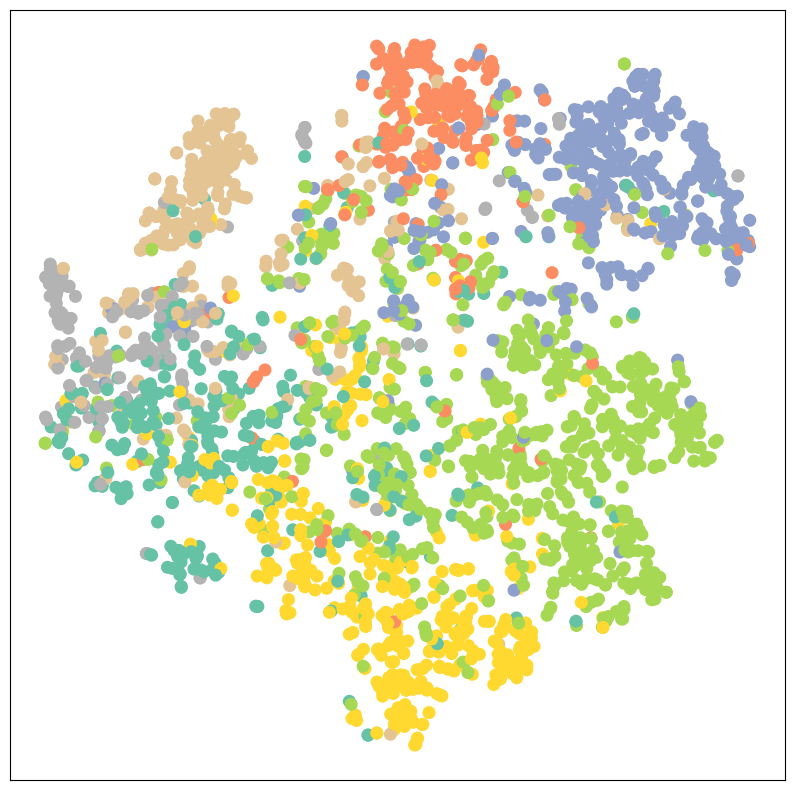

Epoch: 100, Loss: 0.1139


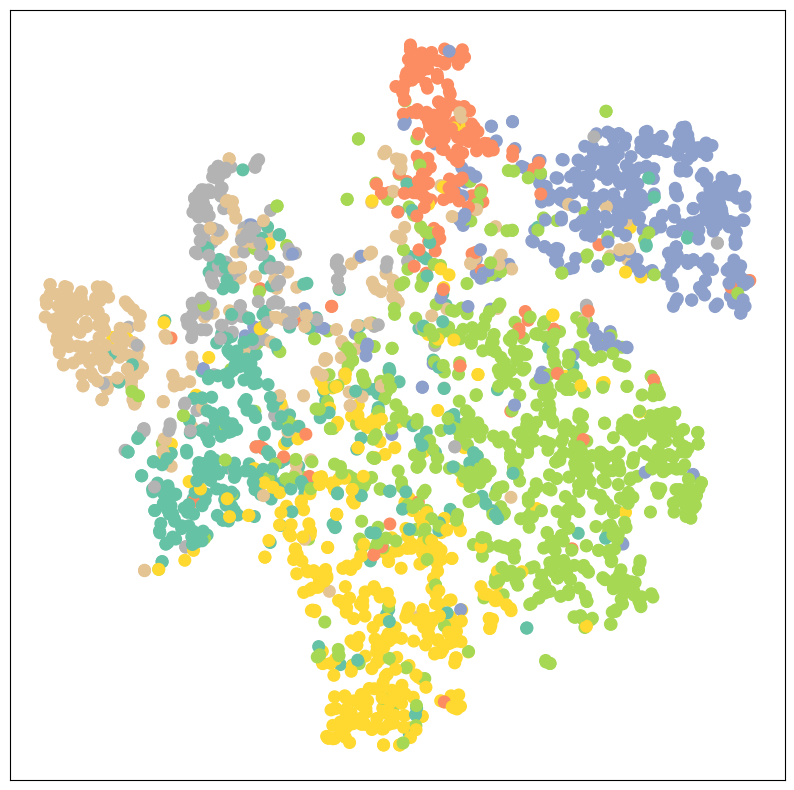

Epoch: 150, Loss: 0.0583


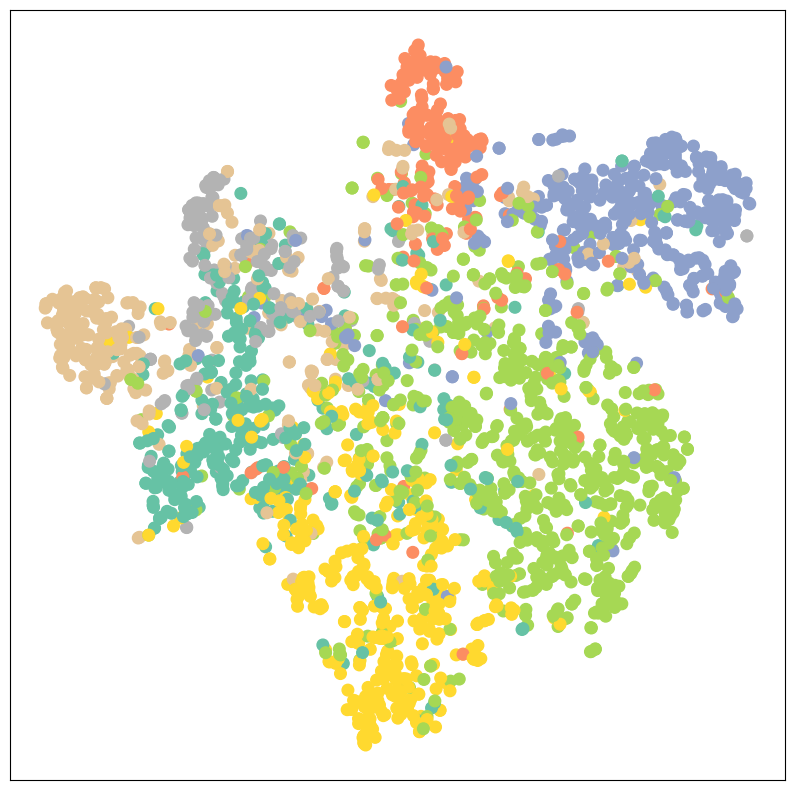

Epoch: 200, Loss: 0.0370


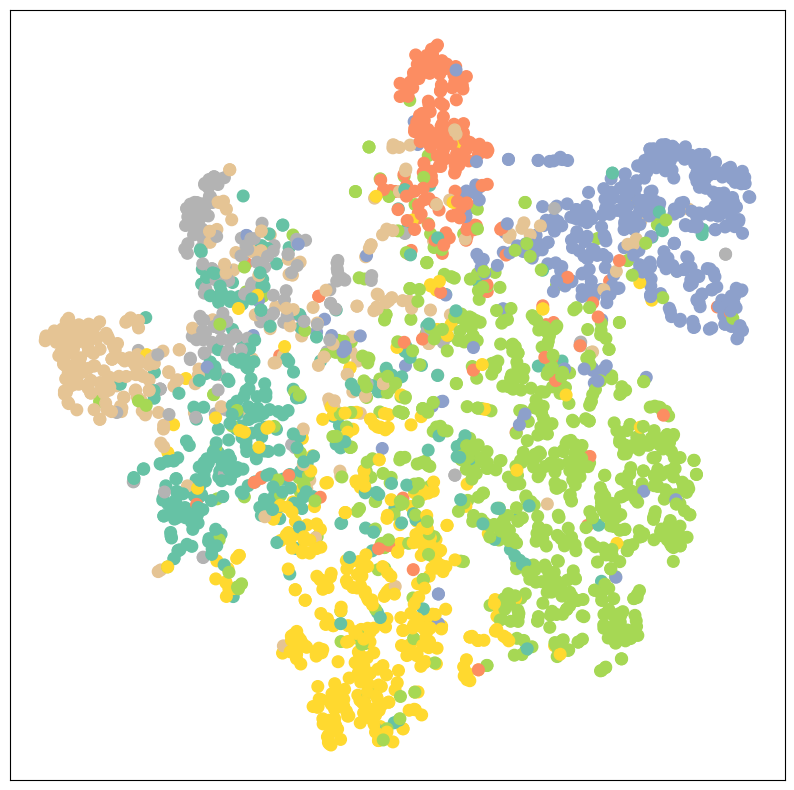

In [9]:
import time as time

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.09)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(1,201):
    loss, h = train(data)
    if epoch % 50 == 0:
        print(f'Epoch: {epoch:03d}, Loss: {loss:.4f}')
        visualize(h, color=data.y)
        time.sleep(0.3)

In [ ]:
def test():
      model.eval()
      out = model(data.x, data.edge_index) 
      pred = out[0].argmax(dim=-1)  # Use the class with highest probability.  
      correct = (pred == data.y).sum().item()  # Number of correct predictions
      total = data.y.size(0)  # Total number of nodes
      test_acc = correct / total 
      return test_acc

test_acc = test()
print(f'Test Accuracy: {test_acc:.4f}')

Test Accuracy: 0.7445
